# Tutorial 1:

### 1.0 Setup

In [2]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 Data

This tutorial follows our text box and replicates the "Airline" example on page 62.

In [3]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive")

# read in the Melbourne Housing data set
airline = pd.read_csv('./gdrive/MyDrive/Colab Notebooks/airline.csv')
airline.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Year,Month,Passengers
0,49,1,112
1,49,2,118
2,49,3,132
3,49,4,129
4,49,5,121


We can now recycle a bunch of code that we used for the previous homework problems to include a time trend and monthly dummy variables.

In [4]:
# add a time trend
airline['trend'] = list(range(1,len(airline.Passengers)+1,1))

# use pandas "get_dummies" to convert the month column into binary indicators/dummies that we join to the dataset
airline = airline.join(pd.get_dummies(airline.Month))
airline.columns

# drop first monthly dummy to avoid multicoliniarity
airline = airline.drop(1,axis=1)
airline.head()

,Year,Month,Passengers,trend,2,3,4,5,6,7,8,9,10,11,12
0,49,1,112,1,0,0,0,0,0,0,0,0,0,0,0
1,49,2,118,2,1,0,0,0,0,0,0,0,0,0,0
2,49,3,132,3,0,1,0,0,0,0,0,0,0,0,0
3,49,4,129,4,0,0,1,0,0,0,0,0,0,0,0
4,49,5,121,5,0,0,0,1,0,0,0,0,0,0,0


Following the book, let's get a quick look at the Passengers data

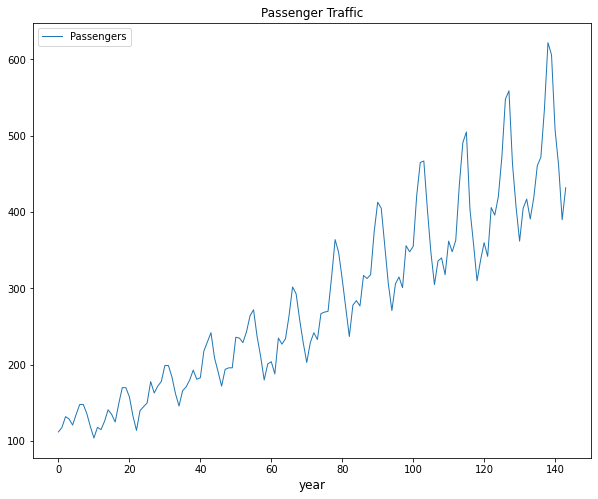

In [5]:
ax = airline[['Passengers']].plot(lw=1)
ax.set_xlabel('year', fontsize=12)
plt.title("Passenger Traffic")
plt.show()

We see that the volatility seems to increase over time. Moreover, passenger volume is usually dicussed in percentage terms. Both suggests using a log-scale. Additionally, the data seems to oscillate around an upward trend, which suggests including a time trend in the regression.

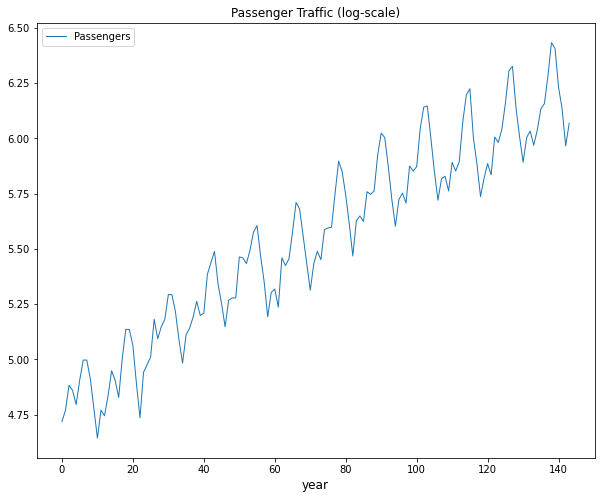

In [6]:
ax = np.log(airline[['Passengers']]).plot(lw=1)
ax.set_xlabel('year', fontsize=12)
plt.title("Passenger Traffic (log-scale)")
plt.show()

Indeed, after applying the log-scale, the oscialltions in the data seem to be roughly constant.

### 1.2 Estimation

With the basic data ready, we can already turn to estimation. Let's again use the OLS class that we created. Since we are interested in the predictions this time, we need to make another tiny adjustment that allows us to read out the residuals as well as the fitted values.

In [7]:
class OLS:

    """
    This code implements a simple OLS regression. The inputs Y and X must be in numpy matrix format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')
    
    # here I moved the actual regression into its own function to streamline the bootstrap code
    def get_betas(self, YY, XX):
        
        #Estimate the beta coefficients
        return np.linalg.inv(XX.T @ XX) @ (XX.T @ YY)
    
    
    def estimate(self, se_method = 'standard', B = 1000):
        
        #unpack Y and X
        Y, X = self.Y, self.X
        
        # If not input is given, we simply use standard standard errors. It is useful to also print a message to 
        # to make users aware of the standard_errors used
        print("Standard Errors computed using method:", se_method)
        
        # run the OLS regression by calling the get_betas() function
        self.beta = self.get_betas(Y, X)
        
        # return the fitted values
        self.Y_hat = X @ self.beta
        
        # return regression residuals
        self.eps = Y - X @ self.beta
        
        # compute R^2
        MSE = np.mean(np.square(self.eps),axis=0)
        self.R2 = 1 - MSE/np.var(Y)

        
        # ------------------------------------------------------------------------------------------------------
        
        if se_method == 'standard':
            #compute the regression residuals
            eps = Y - X @ self.beta
        
            #compute the residual variance
            s_hat = 1/(Y.shape[0] - self.beta.shape[0]) * eps.T @ eps
            
            #compute the standard errors
            self.se = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())).reshape((self.beta.shape[0],1))
            
            #compute confidence intervals
            CI_upper = self.beta + stats.norm.ppf(0.975)*self.se
            CI_lower = self.beta - stats.norm.ppf(0.975)*self.se
        
        elif se_method == 'bootstrap':
            print("Number of Bootstrap samples:", B)
            
            # initialize the array of bootstrap estimates
            self.bootstrapbeta = np.empty([self.beta.shape[0],B])
            
            # compute the coefficients over the bootstrap sample
            for i in range(B):
                
                # generate a vector of randomly drawn indices with replacement
                random_indices = np.random.choice(Y.shape[0], size=Y.shape[0], replace=True)
                
                # select the corresponding rows of Y and X
                Y_b = Y[random_indices]
                X_b = X[random_indices]
                
                # compute the regression coefficients for the bootstrap samples
                beta = self.get_betas(Y_b, X_b)
                
                # collect all bootstrap coefficients
                self.bootstrapbeta[:,i] = beta.ravel()
                
            # compute bootstrap standard errors
            self.se = np.sqrt(np.mean(np.square(self.bootstrapbeta-self.beta),axis=1)).reshape((self.beta.shape[0],1))
        
            #compute the bootstrap confidence intervals
            CI_upper = self.beta + 2*self.se
            CI_lower = self.beta - 2*self.se
        
        # ------------------------------------------------------------------------------------------------------
        
        #compute t-statistic for standard hypothesis test
        t = np.abs(self.beta/self.se)

        #compute p-values for standard hypothesis test
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        #generate an output table
        outmat = np.concatenate((self.beta,self.se,t,p_vals,CI_lower,CI_upper),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
        
        return table
    
    def hypothesis_test(self,i,β_0):
        # here a small if statement tests whether estimates have been computed before. If not, we simply call the
        # "estimate" function of our class
        if hasattr(self, 'beta'):
            beta, se = self.beta, self.se
            print("Previous estimates available. Hypothesis test is conducted based on previous estimates.")
        else:
            self.estimate()
            beta, se = self.beta, self.se
            print("No previous estimates available. Estimating OLS to obtain coefficients.")
        
        
        # compute the test statistic
        t = np.abs((beta[i] - β_0)/se.T[i])
        
        #compute p-values
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        # create output table
        outmat = np.concatenate((t,p_vals),axis=1)
        table = pd.DataFrame(outmat)
        table.columns =['t-statistic','p-value']
        
        return table

We are now ready to build the regression matrices and to run the estimation.

In [8]:
# generate the Y, and X matrices
Y = np.asarray([np.log(airline.Passengers)]).T
X = np.asarray(airline.iloc[:,3:])

# add a constant to the independent variables
X = np.concatenate((np.ones([X.shape[0],1]), X), axis=1)

In [9]:
# define the airline regression object
airline_reg = OLS(Y,X)

In [10]:
# estimate a regression with standard standard errors
airline_reg.estimate()

Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,4.726780,0.018894,250.179734,0.000000e+00,4.689750,4.763811
1,0.010069,0.000119,84.398951,0.000000e+00,0.009835,0.010303
2,-0.022055,0.024211,0.910947,3.623232e-01,-0.069507,0.025398
3,0.108172,0.024212,4.467760,7.904292e-06,0.060718,0.155626
4,0.076903,0.024213,3.176093,1.492731e-03,0.029446,0.124360
5,0.074531,0.024215,3.077842,2.085054e-03,0.027070,0.121992
6,0.196677,0.024218,8.121134,4.440892e-16,0.149211,0.244143
7,0.300619,0.024221,12.411436,0.000000e+00,0.253147,0.348092
8,0.291324,0.024225,12.025791,0.000000e+00,0.243844,0.338805
9,0.146690,0.024229,6.054215,1.411038e-09,0.099201,0.194179


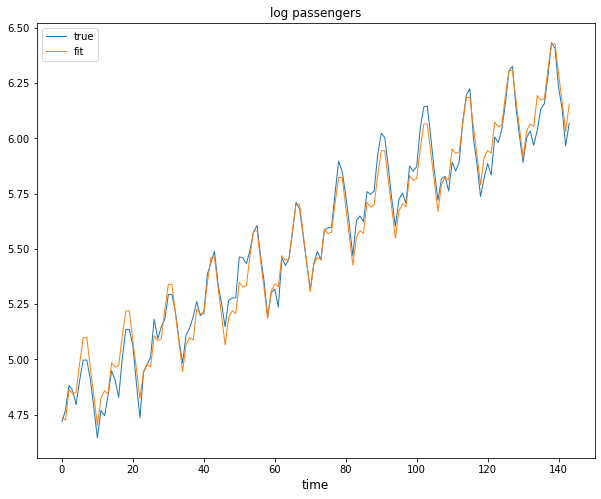

In [11]:
pd.DataFrame(np.concatenate((Y,airline_reg.Y_hat),axis=1))

ax = pd.DataFrame(np.concatenate((Y,airline_reg.Y_hat),axis=1)).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['true','fit'])
plt.title("log passengers")
plt.show()

Like in the book, including a linear trend and monthly dummies seem to do a nice job summarizing the passenger traffic on log-scale. Since our regression only includes a time trend and monthly dummies, the regression residuals correspond to the detrended passenger volume. This is, because we substract all the variation in the data that we can explain with a trend and the dummies from the original data series. Let's now take a look at the detrended data. 

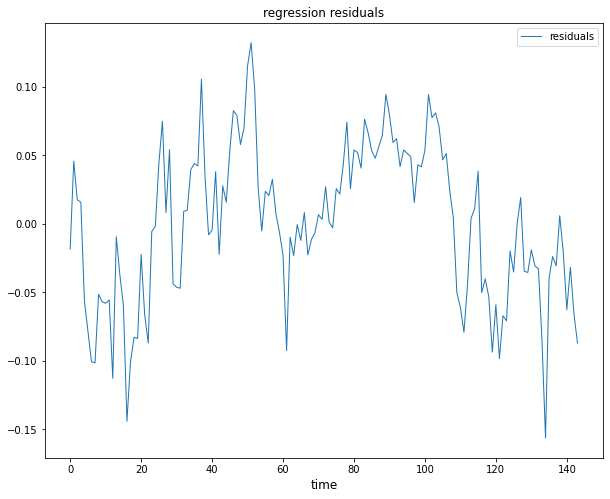

In [12]:
ax = pd.DataFrame(airline_reg.eps).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['residuals'])
plt.title("regression residuals")
plt.show()

As we can see, there seems to be a lot of dependence in the detrended series. Or differently, the residuals appear to be correlated in time. We can recycle the autocorrelation function code that we built in an earlier homework problem to get a closer look at this dependence.

In [13]:
# the lags=[1] sets the default to 1. If no input is given, the function will return the ACF for the 1st lag
def autocorr(x,lags=[1]):
    
    # initilalize the acf vector
    acf = []
    
    # compute the ACF for the desired lags
    for i in lags:
        # compute acf for lag lengths given in l
        ac = np.corrcoef(np.array([x[:-i], x[i:]]))
        
        # extract the upper corner element of the ac matrix
        ac = ac[np.triu_indices(ac.shape[0], k = 1)]
        
        # collect the ACF for all l 
        acf.append(ac.tolist())
    
    # flatten the list of lists into a list
    acf = [item for sublist in acf for item in sublist]
    return acf

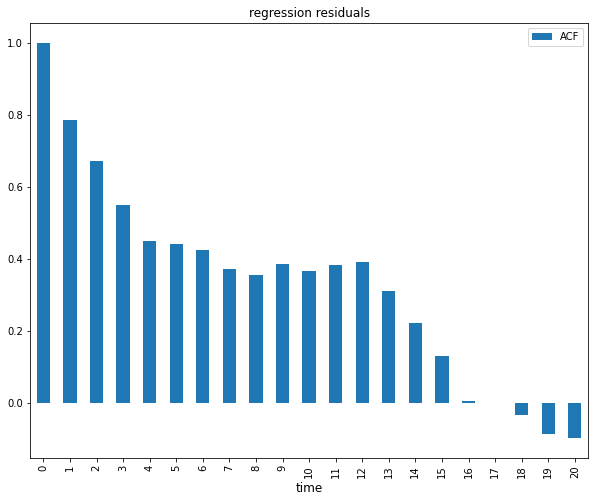

In [14]:
# call the autocorrelation function to compute the autocorrelation coefficient for l=1,5,10
ACF = autocorr(np.asarray(airline_reg.eps).ravel(),list(np.arange(1,21)))


ax = pd.DataFrame(np.append(1,ACF)).plot.bar(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['ACF'])
plt.title("regression residuals")
plt.show()

The autocorrelation coefficient for the first lag is roughly 0.8, which is rather large, and slowly seems to decay afterwards. Based on what we learned in previous classes, we should hence consider using an AR process to model this data. 

In [15]:
# generate the Y, and X matrices. Due to lagging, we loose one observation.
Y = np.asarray(airline_reg.eps[1:])
X = np.asarray(airline.iloc[1:,3:])

# add a constant to the independent variables
X = np.hstack((np.ones([X.shape[0],1]), np.asarray(airline_reg.eps[:-1]) ,X))

# define the airline regression object
airline_reg2 = OLS(Y,X)

In [18]:
airline_reg2.estimate()


Standard Errors computed using method: standard


,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-0.002707,0.012410,0.218103,0.827349,-0.027030,0.021617
1,0.793072,0.054899,14.445923,0.000000,0.685471,0.900672
2,-0.000026,0.000075,0.345754,0.729527,-0.000173,0.000121
3,0.004470,0.015423,0.289860,0.771924,-0.025757,0.034698
4,0.004496,0.015421,0.291572,0.770614,-0.025728,0.034721
5,0.004522,0.015420,0.293277,0.769310,-0.025700,0.034744
6,0.004548,0.015419,0.294976,0.768012,-0.025672,0.034769
7,0.004574,0.015418,0.296668,0.766720,-0.025645,0.034793
8,0.004600,0.015418,0.298353,0.765434,-0.025619,0.034819
9,0.004626,0.015418,0.300031,0.764154,-0.025594,0.034846


In [19]:
print('R^2:', airline_reg2.R2.item())

R^2: 0.6180162528242068


Looking at the output, we immediately see that the lag features a highly significant coefficient that is roughly equal to the value of the ACF for the first lag. Let's now take a look at the residuals and the autocorrelation problem.

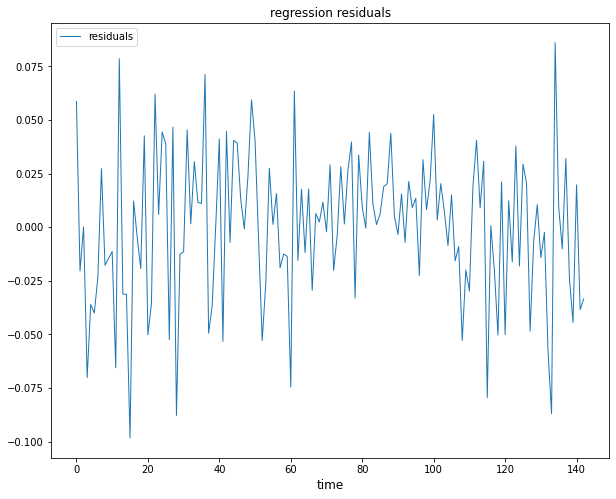

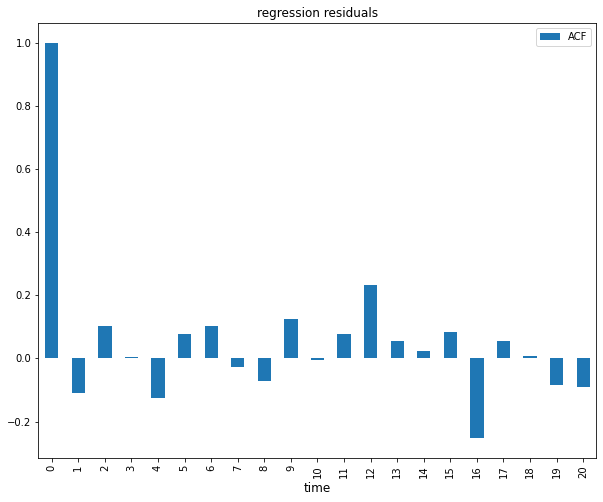

In [20]:
ax = pd.DataFrame(airline_reg2.eps).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['residuals'])
plt.title("regression residuals")
plt.show()

# call the autocorrelation function to compute the autocorrelation coefficient for l=1,5,10
ACF = autocorr(np.asarray(airline_reg2.eps).ravel(),list(np.arange(1,21)))


ax = pd.DataFrame(np.append(1,ACF)).plot.bar(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['ACF'])
plt.title("regression residuals")
plt.show()

Including a single lag seems to have solved the issue. The regression residuals don't seem to feature much dependence and now look more like a white noise process. The ACF confirms this impression.

### 1.3 Out-of-sample forecasting

We now have all ingredients we need to compute forecasts. In this example, let's compute monthly forecasts for 12 months ahead/the following year. The procedure involves projecting the model forward in time:

* predict the t+1 value conditional on time t
* predict the t+1 value using the prediction for t+1
* ...

In addition, we also have to take care of the trend and the monthly dummies. Since these variables are predetermined, however, we simply need to be careful to assign the correct values in all future periods. 

Recall the structure of the predetermined variables:

In [21]:
airline.iloc[1:,3:]

,trend,2,3,4,5,6,7,8,9,10,11,12
1,2,1,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
139,140,0,0,0,0,0,0,1,0,0,0,0
140,141,0,0,0,0,0,0,0,1,0,0,0
141,142,0,0,0,0,0,0,0,0,1,0,0
142,143,0,0,0,0,0,0,0,0,0,1,0


If you look carefully, you might spot that the monthly dummies are like an identity matrix with the first column missing. We can exploit this feature to create the necessary time series. 

In [22]:
# generate the monthly dummies for future months
mm = np.eye(12)
mm = mm[:,1:]
mm

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

To generate the trend, we can simply generate a sequence of 12 values and add the last value of the trend to it.

In [23]:
# generate values for the future trend
tt = np.arange(1,13)+airline.iloc[-1,3]
tt

array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156])

In [24]:
XX = np.hstack((np.asarray(tt).reshape((mm.shape[0],1)), mm))

We are now ready to compute the forecasts.

In [25]:
Y_fore = np.empty([13,1])
Y_fore[0] = Y[-1]

# generate the forecasts
for i in np.arange(1,13):
    Y_fore[i] = np.hstack((np.ones([1]),Y_fore[i-1],XX[i-1])) @ airline_reg2.beta

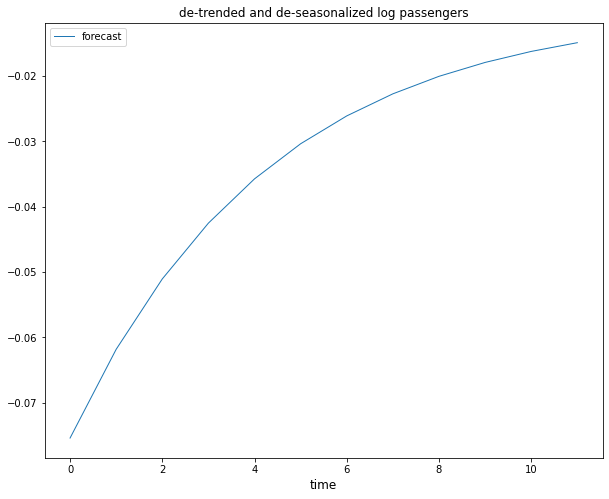

In [26]:
# plot the forecast
ax = pd.DataFrame(Y_fore[1:]).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['forecast'])
plt.title("de-trended and de-seasonalized log passengers")
plt.show()

We can now also add back our trend and the seasonal pattern in the data.

In [27]:
Y_fore_2 = np.empty([13,1])

# predict the seasonal pattern and trend
for i in np.arange(1,13):
    Y_fore_2[i] = np.hstack((np.ones([1]),XX[i-1])) @ airline_reg.beta

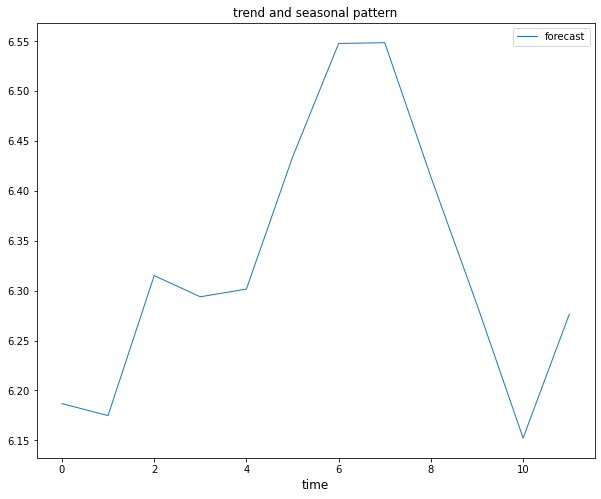

In [28]:
# plot the forecast
ax = pd.DataFrame(Y_fore_2[1:]).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['forecast'])
plt.title("trend and seasonal pattern")
plt.show()

We can now add the seasonal pattern and trend back to our data. This results in predictions of the log passengers.

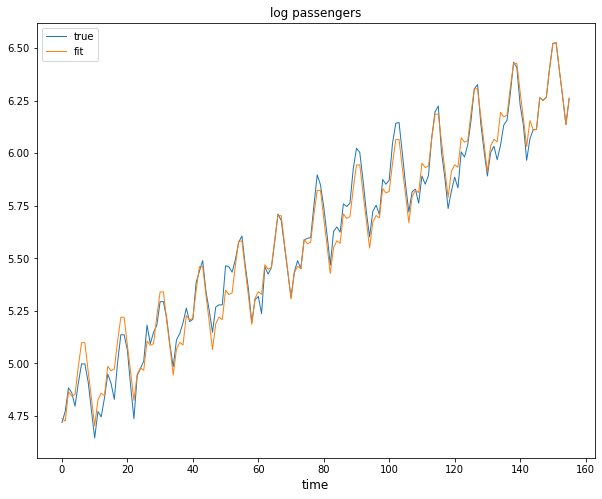

In [29]:
fore = Y_fore+Y_fore_2

Y = np.matrix([np.log(airline.Passengers)]).T
np.concatenate((airline_reg.Y_hat,fore[1:]))


ax = pd.DataFrame(np.concatenate((np.concatenate((Y,fore[1:])),np.concatenate((airline_reg.Y_hat,fore[1:]))),axis=1)).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['true','fit'])
plt.title("log passengers")
plt.show()

In addition, we can apply the exponential function and retrieve forecasts for the original input data.

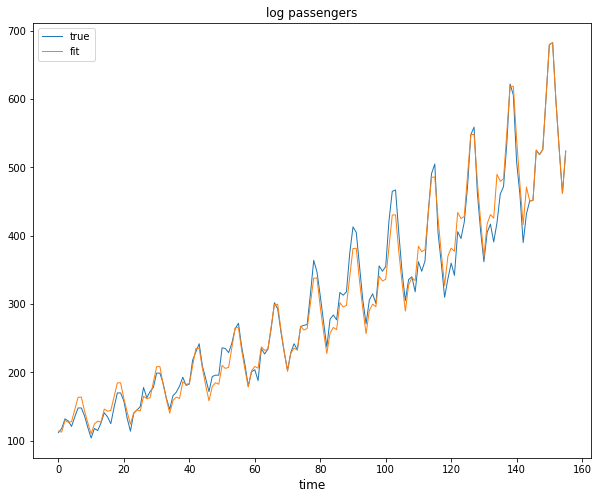

In [30]:
fore = Y_fore+Y_fore_2

Y = np.matrix([np.log(airline.Passengers)]).T
np.concatenate((airline_reg.Y_hat,fore[1:]))


ax = pd.DataFrame(np.concatenate((np.concatenate((np.exp(Y),np.exp(fore[1:]))),np.concatenate((np.exp(airline_reg.Y_hat),np.exp(fore[1:])))),axis=1)).plot(lw=1)
ax.set_xlabel('time', fontsize=12)
ax.legend(['true','fit'])
plt.title("log passengers")
plt.show()

We have now successfully generated out-of-sample forecats for the original data by reversing our data manipulation steps. This shows that simple models can actually go a long way, once seasonality, trands, and autocorrelation are appropriately accounted for. 